## Neural Unveil: Journey into Layer Activations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.cm as cm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

In [4]:
first_image, first_label = mnist_test[0]
second_image, second_label = mnist_test[1]

In [5]:
class MNISTModel(nn.Module):

  def __init__(self, input_layer, h1, h2, h3, output_layer):
    super().__init__()
    self.fc1 = nn.Linear(input_layer, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.out = nn.Linear(h3, output_layer)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    x = self.fc3(x)
    x = torch.relu(x)
    x = self.out(x)

    return x

In [6]:
input_layer = 784
h1 = 100
h2 = 100
h3 = 100
output_layer = 10
learning_rate = 0.001
epochs = 10

In [7]:
torch.manual_seed(2024)
model = MNISTModel(input_layer, h1, h2, h3, output_layer)

In [8]:
def MNISTTrain(model, epochs, learning_rate, data_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  loss_list = []
  accuracy_list = []

  for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(data_loader, 0):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == labels).sum().item()
      total_samples += labels.size(0)
      epoch_accuracy = correct_predictions / total_samples
    #print(f"Epoch {epoch+1}, Loss: {running_loss}")
    loss_list.append(running_loss)
    accuracy_list.append(epoch_accuracy)
    #print(loss_list)

  fig, axs = plt.subplots(1, 2)


  #axs[0].subplot(1, 2, 1)
  axs[0].plot(range(epochs), loss_list, label = 'loss', c = 'red')
  axs[0].set_xlabel("Ephoc")
  axs[0].set_ylabel("Loss")
  axs[0].legend()
  #axs[0].show()

  #axs[1].subplot(1, 2, 2)
  axs[1].plot(range(epochs), accuracy_list, label = 'accuracy', c = 'green')
  axs[1].set_xlabel("Ephoc")
  axs[1].set_ylabel("Accuracy")
  axs[1].legend()
  #axs[1].show()

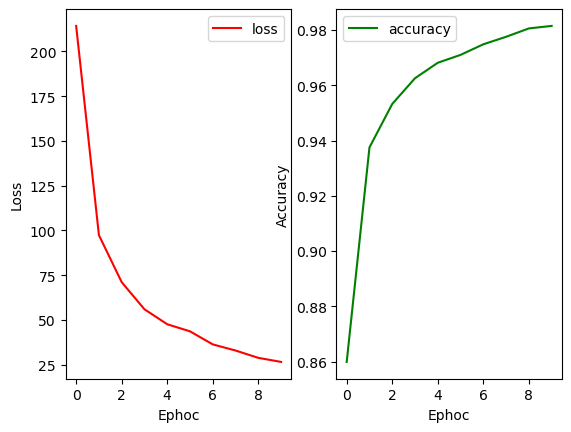

In [9]:
MNISTTrain(model, epochs, learning_rate, mnist_train_loader)

In [10]:
correct = 0
total = 0
with torch.no_grad():
  for data in mnist_test_loader:
    images, labels = data
    outputs = model(images)
    _,predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Accuracy on MNIST test set: {100 * correct / total}%")

Accuracy on MNIST test set: 97.64%


In [11]:
layer_name = "fc1"
layer = getattr(model, layer_name)
layer_gradients = layer.weight.data.numpy()
layer_bias_gradients = layer.bias.data.numpy()

In [12]:
def layerGradientPlot(layer_name, model, p1, p2):
  layer = getattr(model, layer_name)
  layer_gradients = layer.weight.data.numpy()

  #print(layer_gradients.shape)
  gradients_reshaped = layer_gradients.reshape(layer_gradients.shape[0], p1, p2)
  normalized_data = (gradients_reshaped - np.min(gradients_reshaped))/(np.max(gradients_reshaped) - np.min(gradients_reshaped))
  cmap = cm.hsv
  plt.figure(figsize=(10, 10))
  if (layer_gradients.shape[0]%10 == 0):
    num_subplots = int((layer_gradients.shape[0])//10)
  else:
    num_subplots = int((layer_gradients.shape[0])//10) + 1

  #print(normalized_data[1])
  for i in range(normalized_data.shape[0]):
    data = normalized_data[i, :, :]
    rgb_array = cmap(data)
    plt.subplot(num_subplots, 10, i + 1)
    plt.imshow(rgb_array, aspect='equal')
    plt.axis("off")

  plt.tight_layout()
  plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.05, hspace=0.05)
  plt.show()

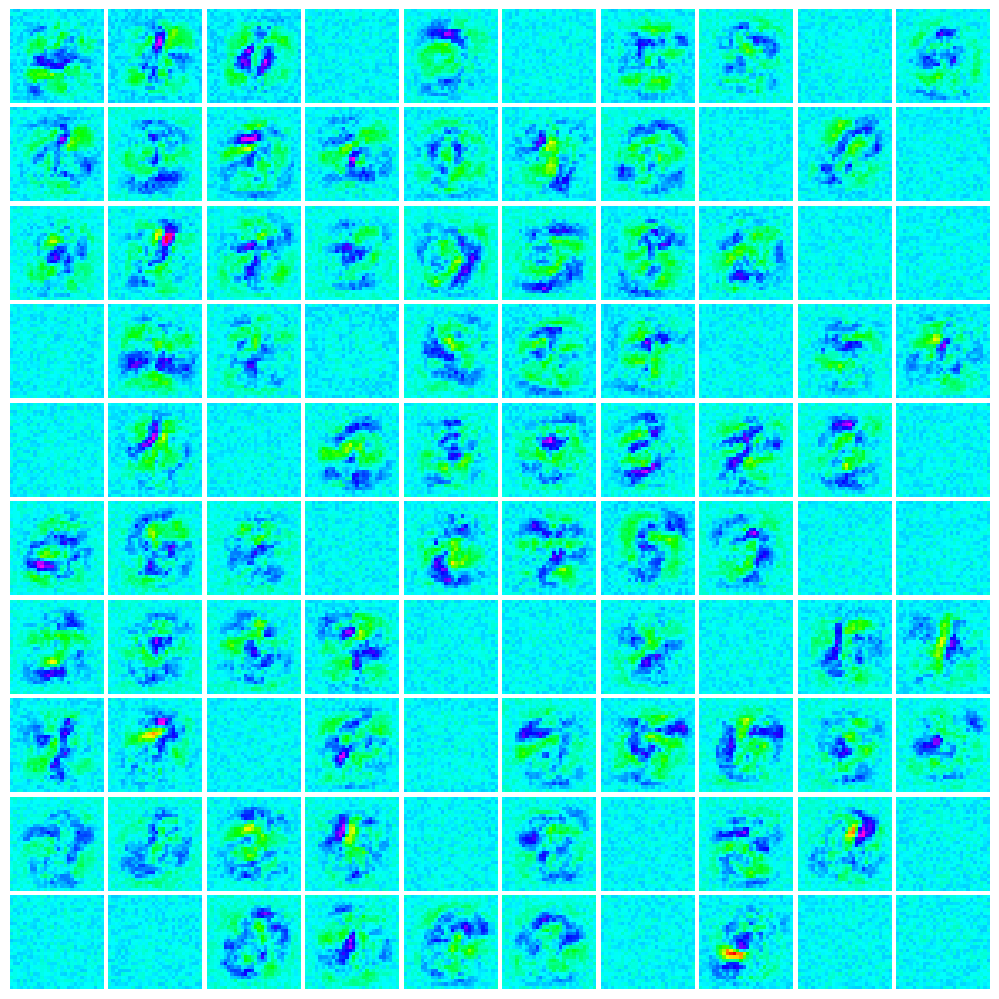

In [13]:
layerGradientPlot('fc1', model, 28, 28)

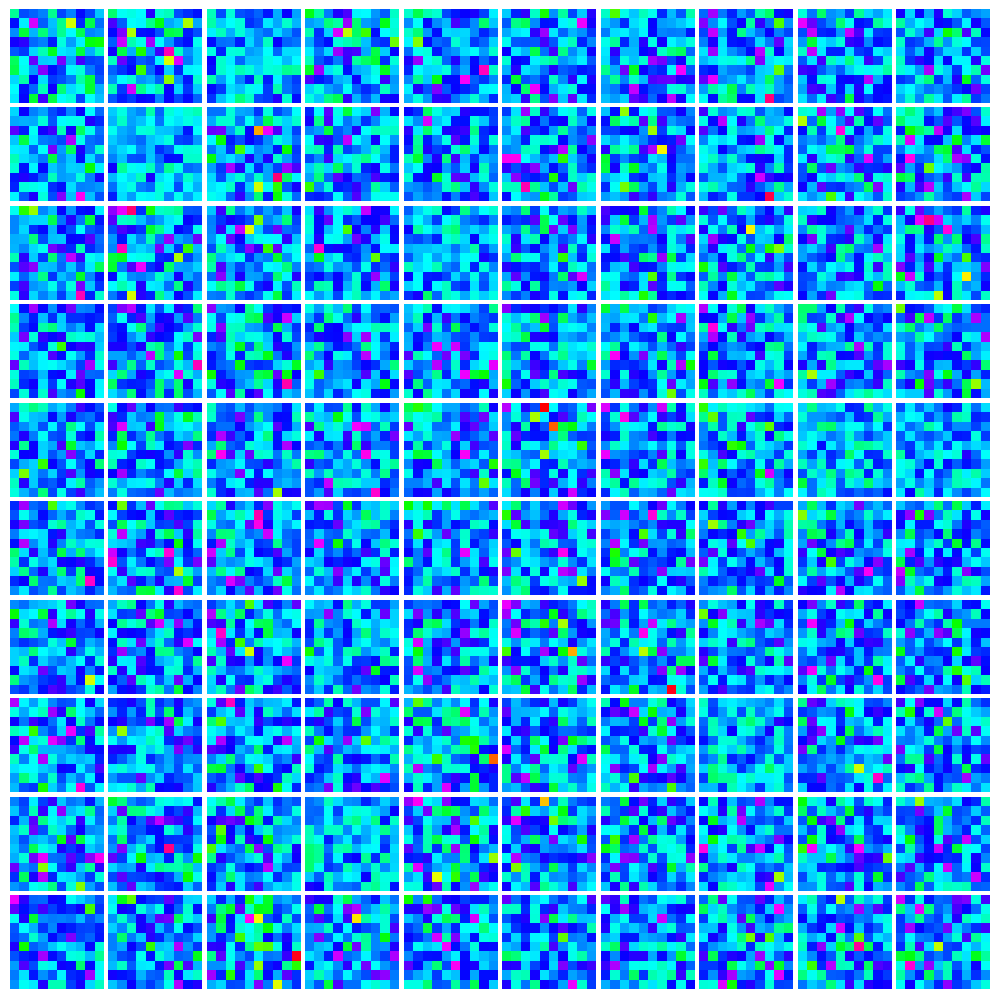

In [14]:
layerGradientPlot('fc2', model, 10, 10)

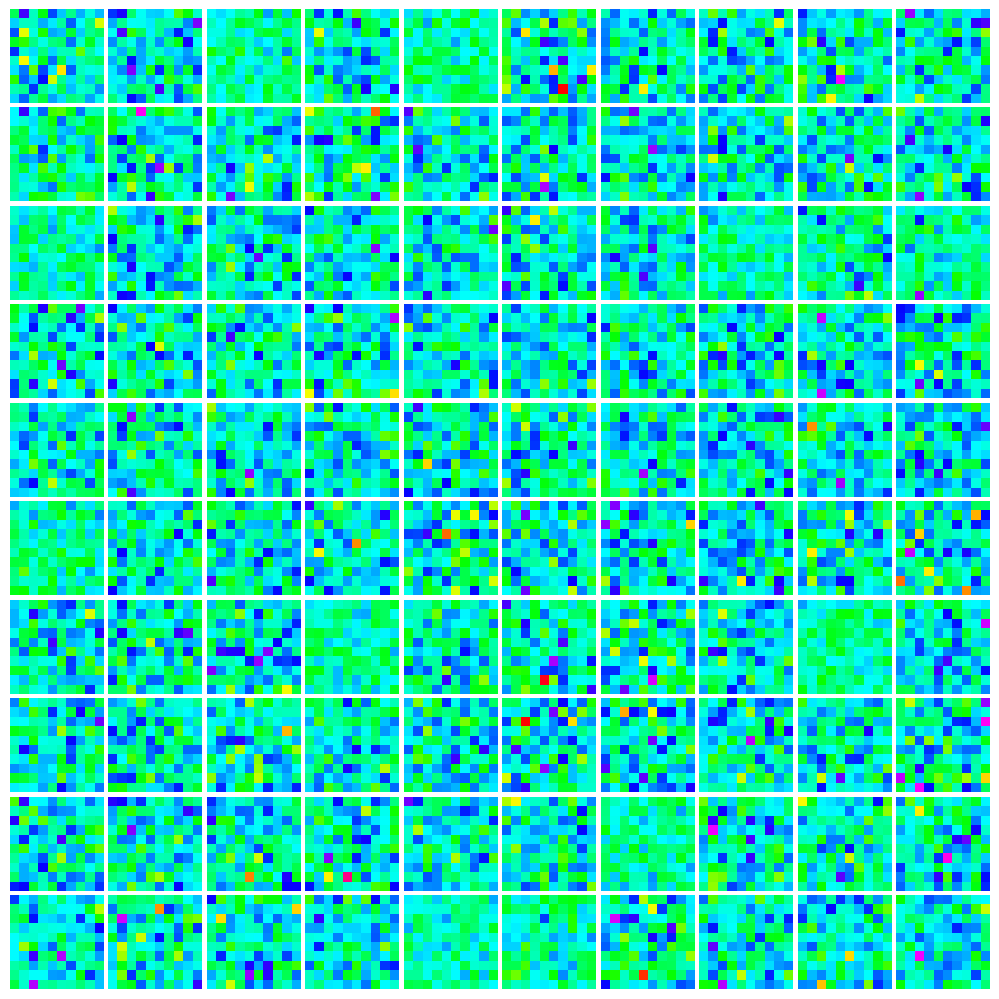

In [16]:
layerGradientPlot('fc3', model, 10, 10)

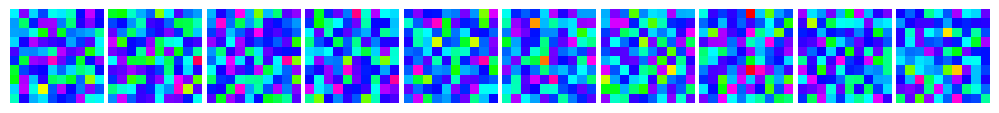

In [17]:
layerGradientPlot('out', model, 10, 10)